In [3]:
import numpy as np
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit
from qiskit.algorithms import QAOA
from qiskit.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit.opflow import I, X, Z, StateFn, PauliSumOp
from random import randint

# Define the Max-Cut problem in terms of an adjacency matrix (example graph)
def create_maxcut_operator(adj_matrix):
    """Create a PauliSum operator from an adjacency matrix for Max-Cut."""
    num_nodes = len(adj_matrix)
    maxcut_op = 0
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adj_matrix[i][j] == 1:
                maxcut_op += (Z^Z).to_op()
    return maxcut_op

# Multi-Agent QAOA class definition
class MultiAgentQAOA:
    def __init__(self, adj_matrix, num_agents, p=1):
        self.adj_matrix = adj_matrix
        self.num_agents = num_agents
        self.p = p  # Number of QAOA layers
        self.optimizers = [COBYLA()] * num_agents  # One optimizer for each agent
        self.agents = [self.create_qaoa_agent() for _ in range(num_agents)]
        self.backend = Aer.get_backend('statevector_simulator')
        self.quantum_instance = QuantumInstance(self.backend)

    def create_qaoa_agent(self):
        """Create an individual QAOA agent with a specific quantum circuit."""
        # Initialize QAOA operator
        qaoa_operator = create_maxcut_operator(self.adj_matrix)
        
        # Create a quantum circuit for QAOA
        circuit = QuantumCircuit(len(self.adj_matrix))
        qaoa = QAOA(operator=qaoa_operator, p=self.p, optimizer=COBYLA())
        
        return qaoa

    def run_agents(self):
        """Run the QAOA algorithm for all agents."""
        results = []
        for i, agent in enumerate(self.agents):
            result = agent.compute_minimum_eigenvalue(quantum_instance=self.quantum_instance)
            results.append(result)
        return results

    def schedule_transactions(self, results):
        """Schedule blockchain transactions based on the agents' results."""
        # Here we use the results (e.g., cut value or circuit outcome) to make a decision
        transactions = []
        for i, result in enumerate(results):
            # Example: Use the result to prioritize or order transactions
            transactions.append({
                "agent": i,
                "cut_value": result.eigenvalue.real,
                "priority": randint(1, 100)  # Random priority for illustration
            })
        
        # Sort transactions based on cut values or priorities
        sorted_transactions = sorted(transactions, key=lambda x: x['priority'], reverse=True)
        return sorted_transactions

# Example adjacency matrix for a simple graph (4 nodes, edges between 0-1, 1-2, 2-3, and 3-0)
adj_matrix = np.array([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0]
])

# Initialize the multi-agent QAOA system
multi_agent_qaoa = MultiAgentQAOA(adj_matrix=adj_matrix, num_agents=3, p=2)

# Run all agents and collect results
results = multi_agent_qaoa.run_agents()

# Schedule blockchain transactions based on agent results
scheduled_transactions = multi_agent_qaoa.schedule_transactions(results)

# Print the scheduled transactions
for transaction in scheduled_transactions:
    print(f"Agent {transaction['agent']} - Cut Value: {transaction['cut_value']:.4f}, Priority: {transaction['priority']}")


ModuleNotFoundError: No module named 'qiskit.optimizers'

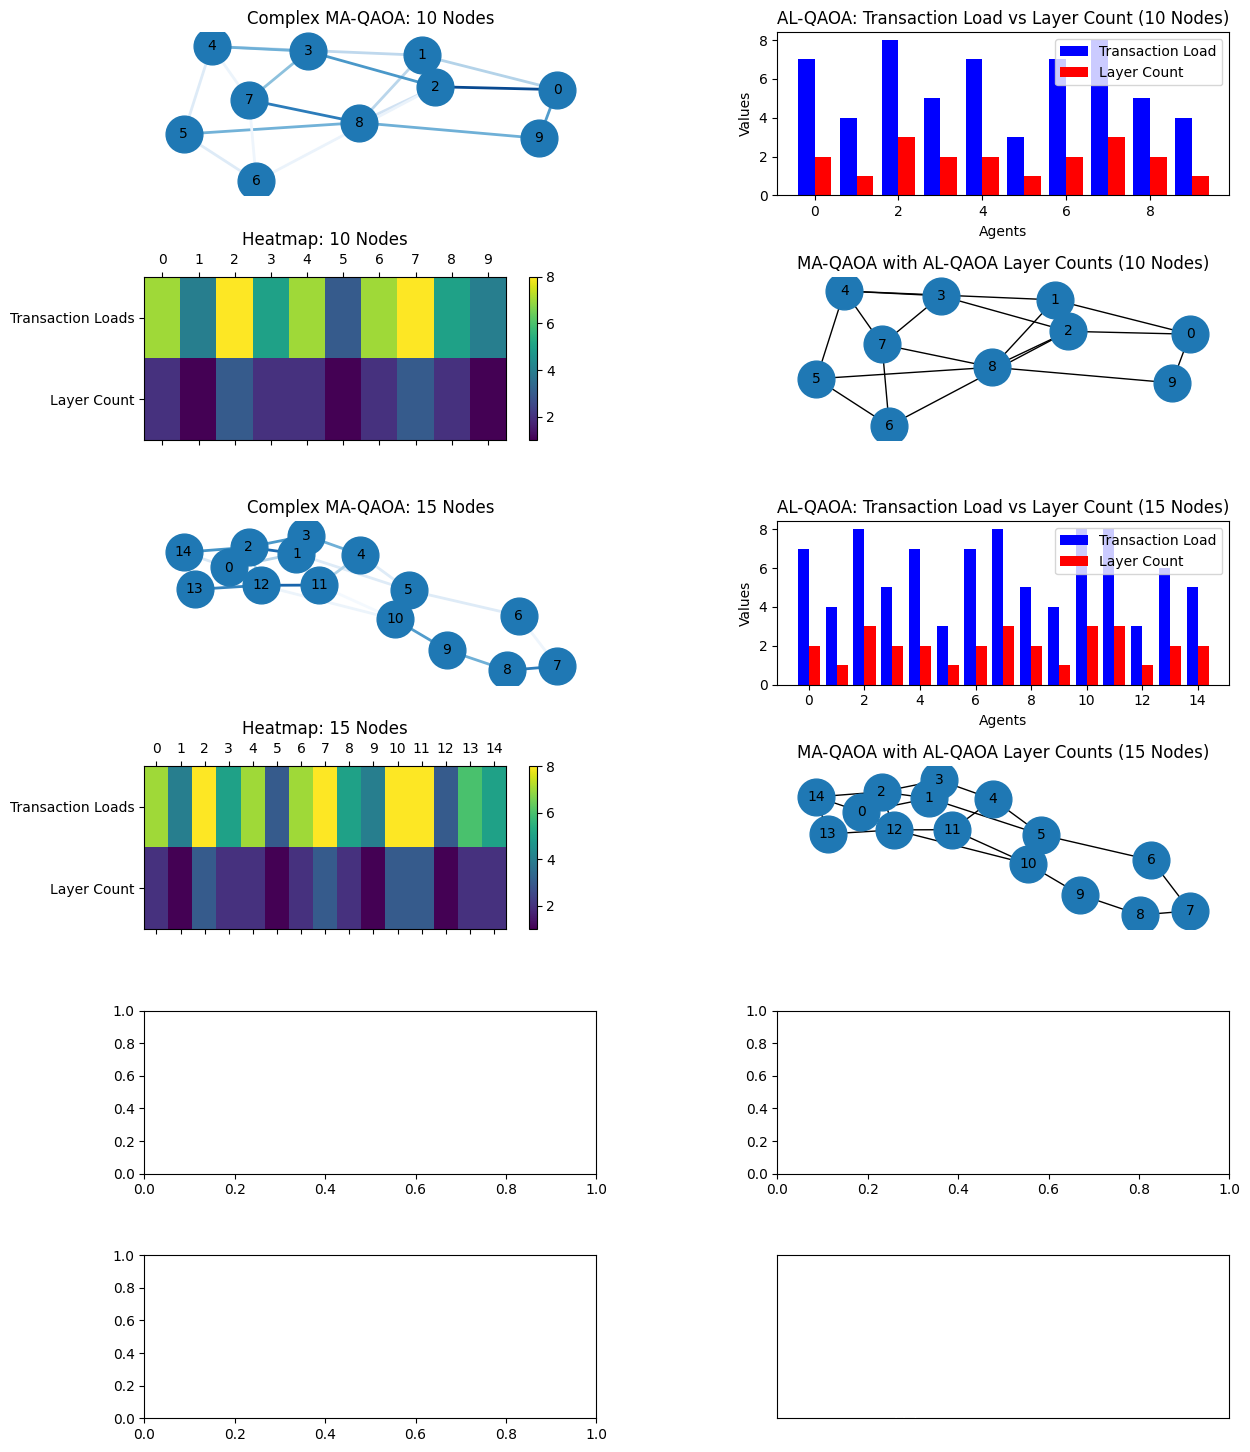

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1. Complex MA-QAOA: Inter-Agent Connectivity
def ma_qaoa_complex_graph(num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    return G

# 2. AL-QAOA: Transaction Load vs Layer Count
def al_qaoa_data(num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    return transaction_loads, layers

# Plotting all graphs in a 2-column layout
def plot_all_graphs():
    fig, axes = plt.subplots(6, 2, figsize=(14, 18))
    plt.subplots_adjust(hspace=0.5, wspace=0.4)

    node_configs = [10, 15]
    graph_idx = 0

    for num_nodes in node_configs:
        # Generate MA-QAOA graph
        G = ma_qaoa_complex_graph(num_nodes=num_nodes)
        pos = nx.spring_layout(G, seed=42)

        # Plot MA-QAOA Graph
        ax = axes[graph_idx, 0]
        nx.draw(
            G, pos, ax=ax, with_labels=True, node_size=700, font_size=10,
            edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
            edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2, width=2
        )
        ax.set_title(f"Complex MA-QAOA: {num_nodes} Nodes")

        # Generate AL-QAOA Data
        transaction_loads, layers = al_qaoa_data(num_agents=num_nodes)

        # Plot AL-QAOA Bar Chart
        ax = axes[graph_idx, 1]
        x = np.arange(num_nodes)
        ax.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
        ax.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
        ax.set_xlabel("Agents")
        ax.set_ylabel("Values")
        ax.set_title(f"AL-QAOA: Transaction Load vs Layer Count ({num_nodes} Nodes)")
        ax.legend()

        graph_idx += 1

        # Combined Representation
        heatmap_data = np.array([transaction_loads, layers])

        # Plot Heatmap
        ax = axes[graph_idx, 0]
        cax = ax.matshow(heatmap_data, cmap='viridis', aspect='auto')
        fig.colorbar(cax, ax=ax)
        ax.set_xticks(range(num_nodes))
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["Transaction Loads", "Layer Count"])
        ax.set_title(f"Heatmap: {num_nodes} Nodes")

        # Overlay on MA-QAOA Graph
        ax = axes[graph_idx, 1]
        node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
        nx.draw(G, pos, ax=ax, with_labels=True, node_size=700, font_size=10)
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white")
        ax.set_title(f"MA-QAOA with AL-QAOA Layer Counts ({num_nodes} Nodes)")

        graph_idx += 1

    plt.show()

# Call the function to plot all graphs
plot_all_graphs()

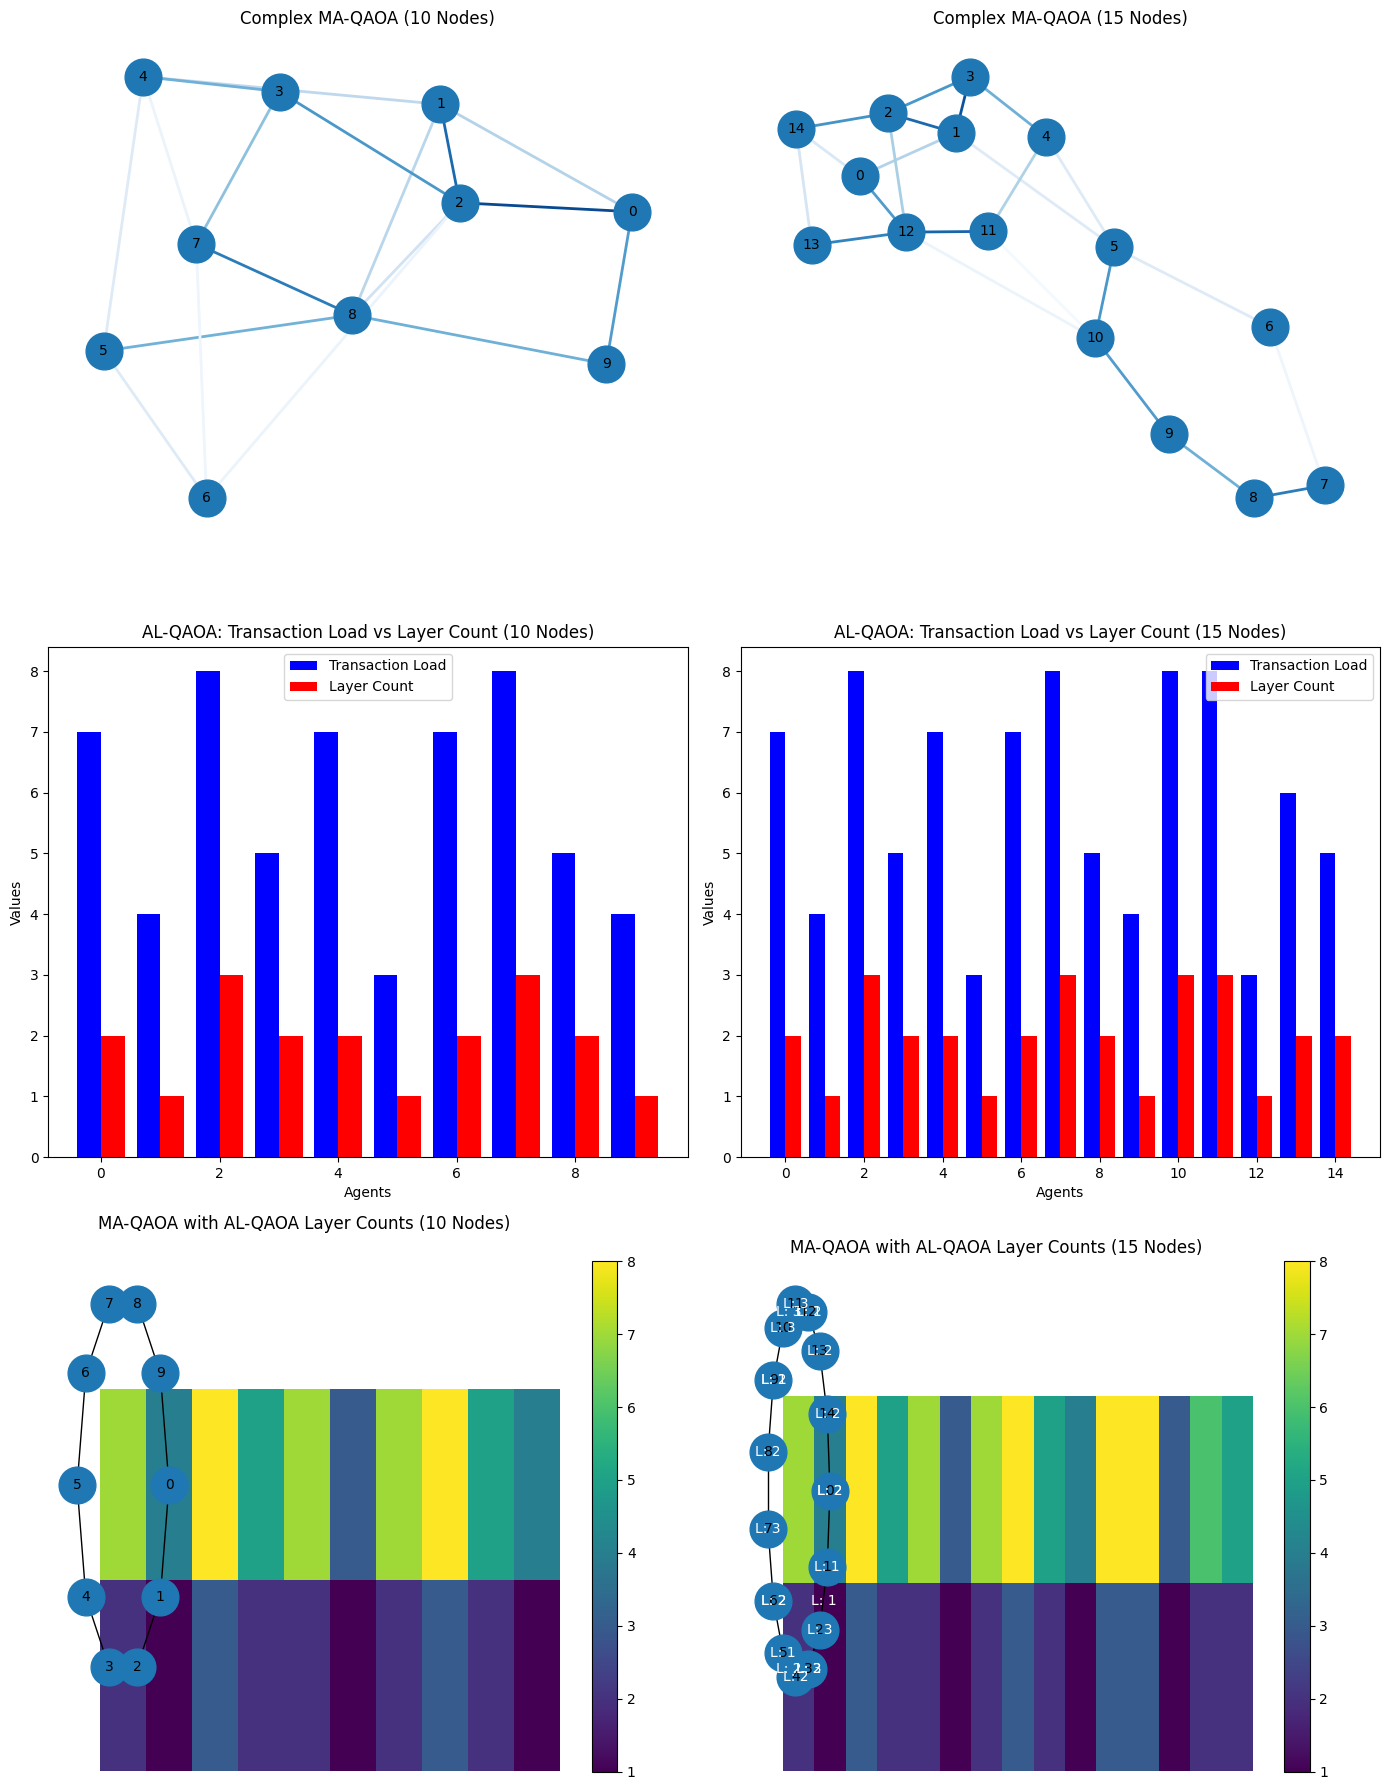

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1. Complex MA-QAOA: Inter-Agent Connectivity
def ma_qaoa_complex_graph(ax, num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    # Draw the graph
    pos = nx.spring_layout(G, seed=seed)  # Force-directed layout for better visualization
    nx.draw(
        G, pos, ax=ax, with_labels=True, node_size=700, font_size=10,
        edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
        edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2,
        width=2
    )
    ax.set_title(f"Complex MA-QAOA ({num_nodes} Nodes)")

# 2. AL-QAOA: Transaction Load vs Layer Count
def al_qaoa_bar_chart(ax, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    x = np.arange(num_agents)
    ax.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
    ax.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
    ax.set_xlabel("Agents")
    ax.set_ylabel("Values")
    ax.set_title(f"AL-QAOA: Transaction Load vs Layer Count ({num_agents} Nodes)")
    ax.legend()

# 3. Combined Representation: Heatmap & Overlay on Graph
def combined_representation(ax1, ax2, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    # Heatmap Data
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    heatmap_data = np.array([transaction_loads, layers])

    # Heatmap
    cax = ax1.matshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(cax, ax=ax1)
    ax1.set_xticks(range(num_agents))
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(["Transaction Loads", "Layer Count"])
    ax1.set_title(f"Combined Representation: Heatmap ({num_agents} Nodes)")

    # Overlay on MA-QAOA Graph
    G = nx.Graph()
    for i in range(num_agents):
        G.add_node(i, layer=layers[i])
    edges = [(i, (i + 1) % num_agents) for i in range(num_agents)]
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax2, with_labels=True, node_size=700, font_size=10)
    node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white")
    ax2.set_title(f"MA-QAOA with AL-QAOA Layer Counts ({num_agents} Nodes)")

# Generate all graphs for 10 and 15 nodes in 2 columns
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
node_counts = [10, 15]

for col, num_nodes in enumerate(node_counts):
    ma_qaoa_complex_graph(axes[0, col], num_nodes=num_nodes)
    al_qaoa_bar_chart(axes[1, col], num_agents=num_nodes)
    combined_representation(axes[2, col], axes[2, col], num_agents=num_nodes)

plt.tight_layout()
plt.show()


Generating for 10 nodes...


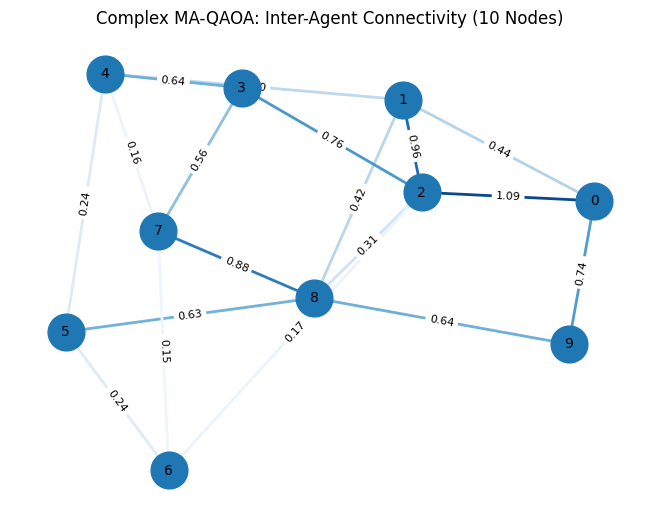

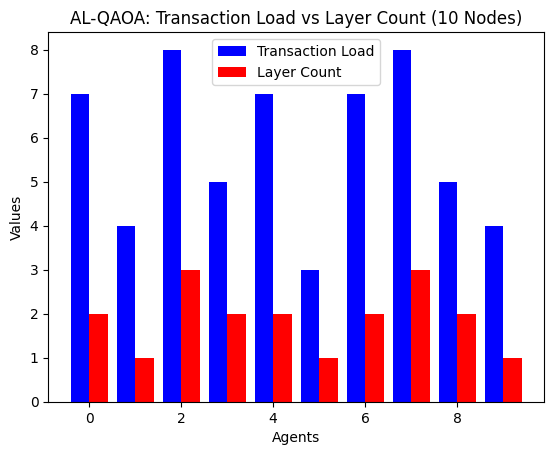

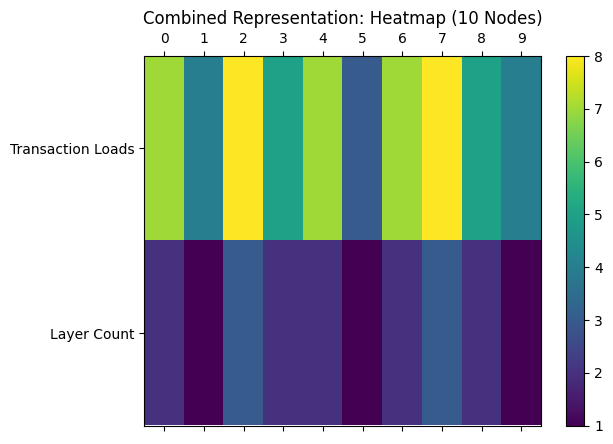

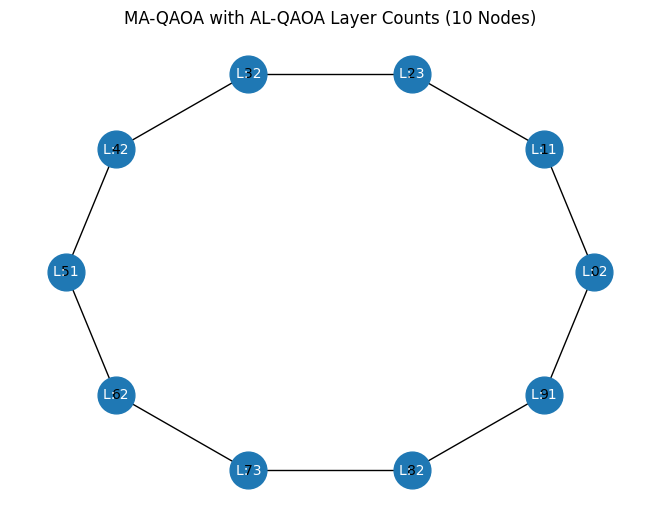

Generating for 15 nodes...


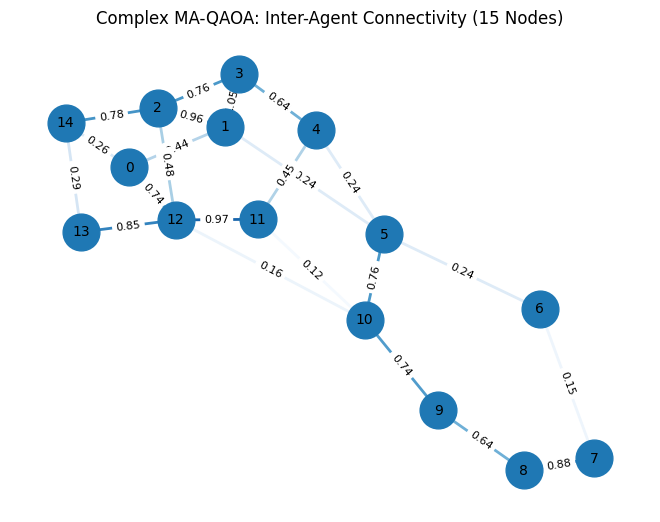

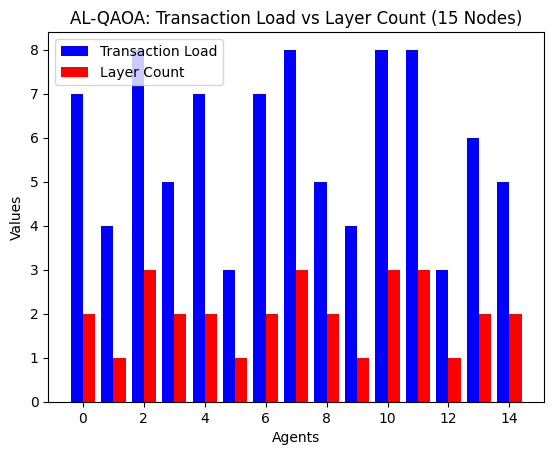

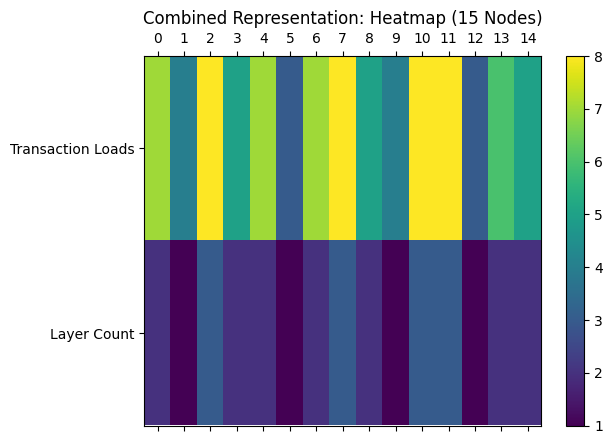

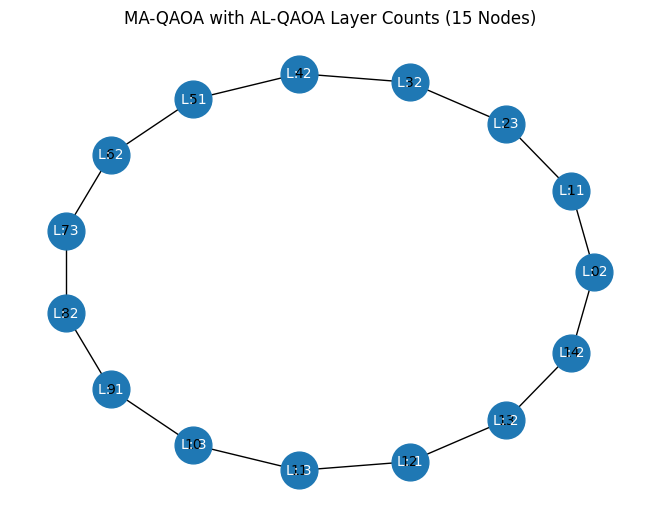

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Complex MA-QAOA: Inter-Agent Connectivity
def ma_qaoa_complex_graph(num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    # Draw the graph
    pos = nx.spring_layout(G, seed=seed)  # Force-directed layout for better visualization
    nx.draw(
        G, pos, with_labels=True, node_size=700, font_size=10,
        edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
        edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2,
        width=2
    )

    # Add edge labels to show weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f"Complex MA-QAOA: Inter-Agent Connectivity ({num_nodes} Nodes)")
    plt.show()

# 2. AL-QAOA: Transaction Load vs Layer Count
def al_qaoa_bar_chart(num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    x = np.arange(num_agents)
    plt.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
    plt.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
    plt.xlabel("Agents")
    plt.ylabel("Values")
    plt.title(f"AL-QAOA: Transaction Load vs Layer Count ({num_agents} Nodes)")
    plt.legend()
    plt.show()

# 3. Combined Representation: Heatmap & Overlay on Graph
def combined_representation(num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    # Heatmap Data
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    heatmap_data = np.array([transaction_loads, layers])

    # Heatmap
    fig, ax = plt.subplots()
    cax = ax.matshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(cax)
    ax.set_xticks(range(num_agents))
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["Transaction Loads", "Layer Count"])
    plt.title(f"Combined Representation: Heatmap ({num_agents} Nodes)")
    plt.show()

    # Overlay on MA-QAOA Graph
    G = nx.Graph()
    for i in range(num_agents):
        G.add_node(i, layer=layers[i])
    edges = [(i, (i + 1) % num_agents) for i in range(num_agents)]
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, font_size=10)
    node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white")
    plt.title(f"MA-QAOA with AL-QAOA Layer Counts ({num_agents} Nodes)")
    plt.show()

# Call the functions for 10 and 15 nodes
for num_nodes in [10, 15]:
    print(f"Generating for {num_nodes} nodes...")
    ma_qaoa_complex_graph(num_nodes=num_nodes)
    al_qaoa_bar_chart(num_agents=num_nodes)
    combined_representation(num_agents=num_nodes)


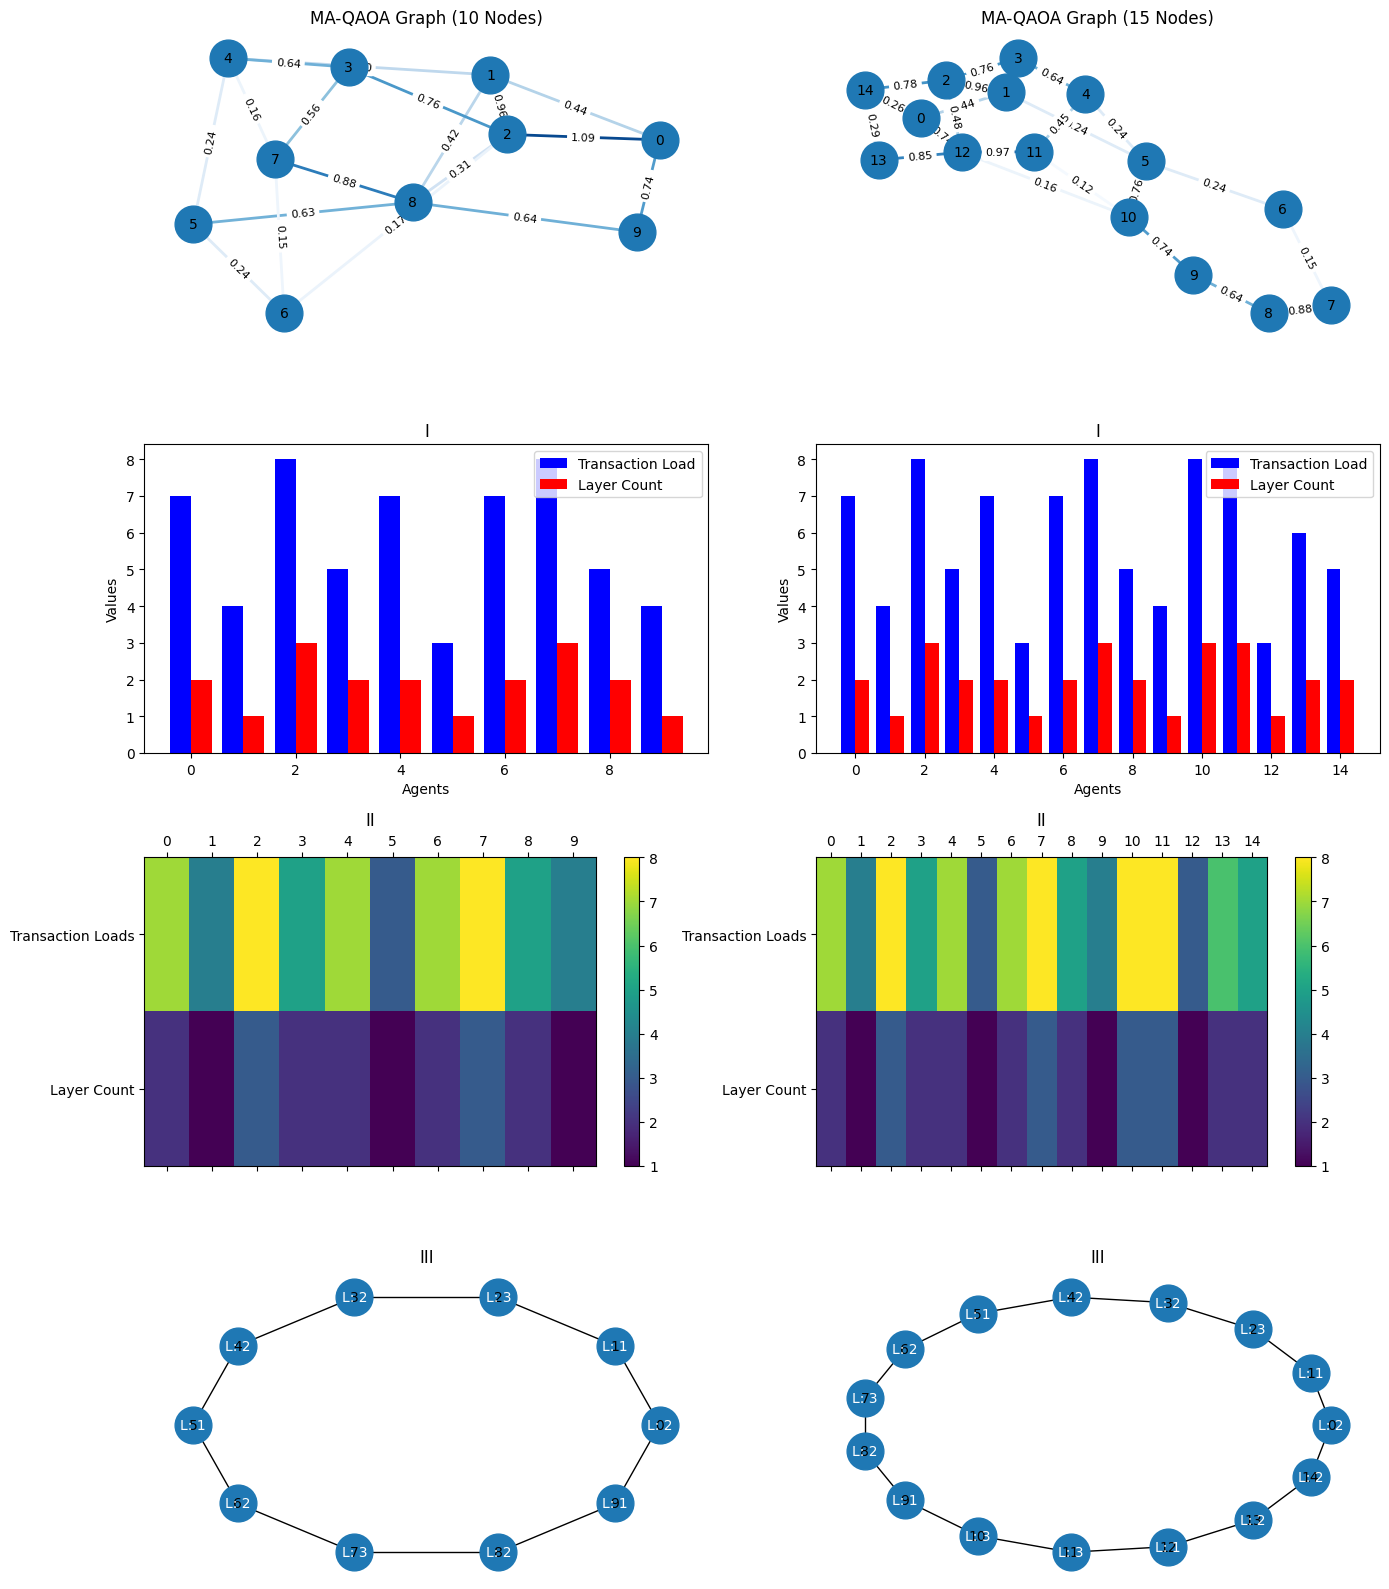

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def ma_qaoa_complex_graph(ax, num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    # Draw the graph
    pos = nx.spring_layout(G, seed=seed)  # Force-directed layout for better visualization
    nx.draw(
        G, pos, ax=ax, with_labels=True, node_size=700, font_size=10,
        edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
        edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2,
        width=2
    )

    # Add edge labels to show weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=8)
    ax.set_title(f"MA-QAOA Graph ({num_nodes} Nodes)")

def al_qaoa_bar_chart(ax, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    x = np.arange(num_agents)
    ax.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
    ax.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
    ax.set_xlabel("Agents")
    ax.set_ylabel("Values")
    ax.set_title("I")
    ax.legend()

def combined_representation(ax1, ax2, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    heatmap_data = np.array([transaction_loads, layers])

    # Heatmap
    cax = ax1.matshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(cax, ax=ax1)
    ax1.set_xticks(range(num_agents))
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(["Transaction Loads", "Layer Count"])
    ax1.set_title("II")

    # Overlay on MA-QAOA Graph
    G = nx.Graph()
    for i in range(num_agents):
        G.add_node(i, layer=layers[i])
    edges = [(i, (i + 1) % num_agents) for i in range(num_agents)]
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax2, with_labels=True, node_size=700, font_size=10)
    node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white", ax=ax2)
    ax2.set_title("III")

# Generate plots for both 10 and 15 nodes
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

for col, num_nodes in enumerate([10, 15]):
    ma_qaoa_complex_graph(axes[0, col], num_nodes=num_nodes)
    al_qaoa_bar_chart(axes[1, col], num_agents=num_nodes)
    combined_representation(axes[2, col], axes[3, col], num_agents=num_nodes)

plt.tight_layout()
plt.show()


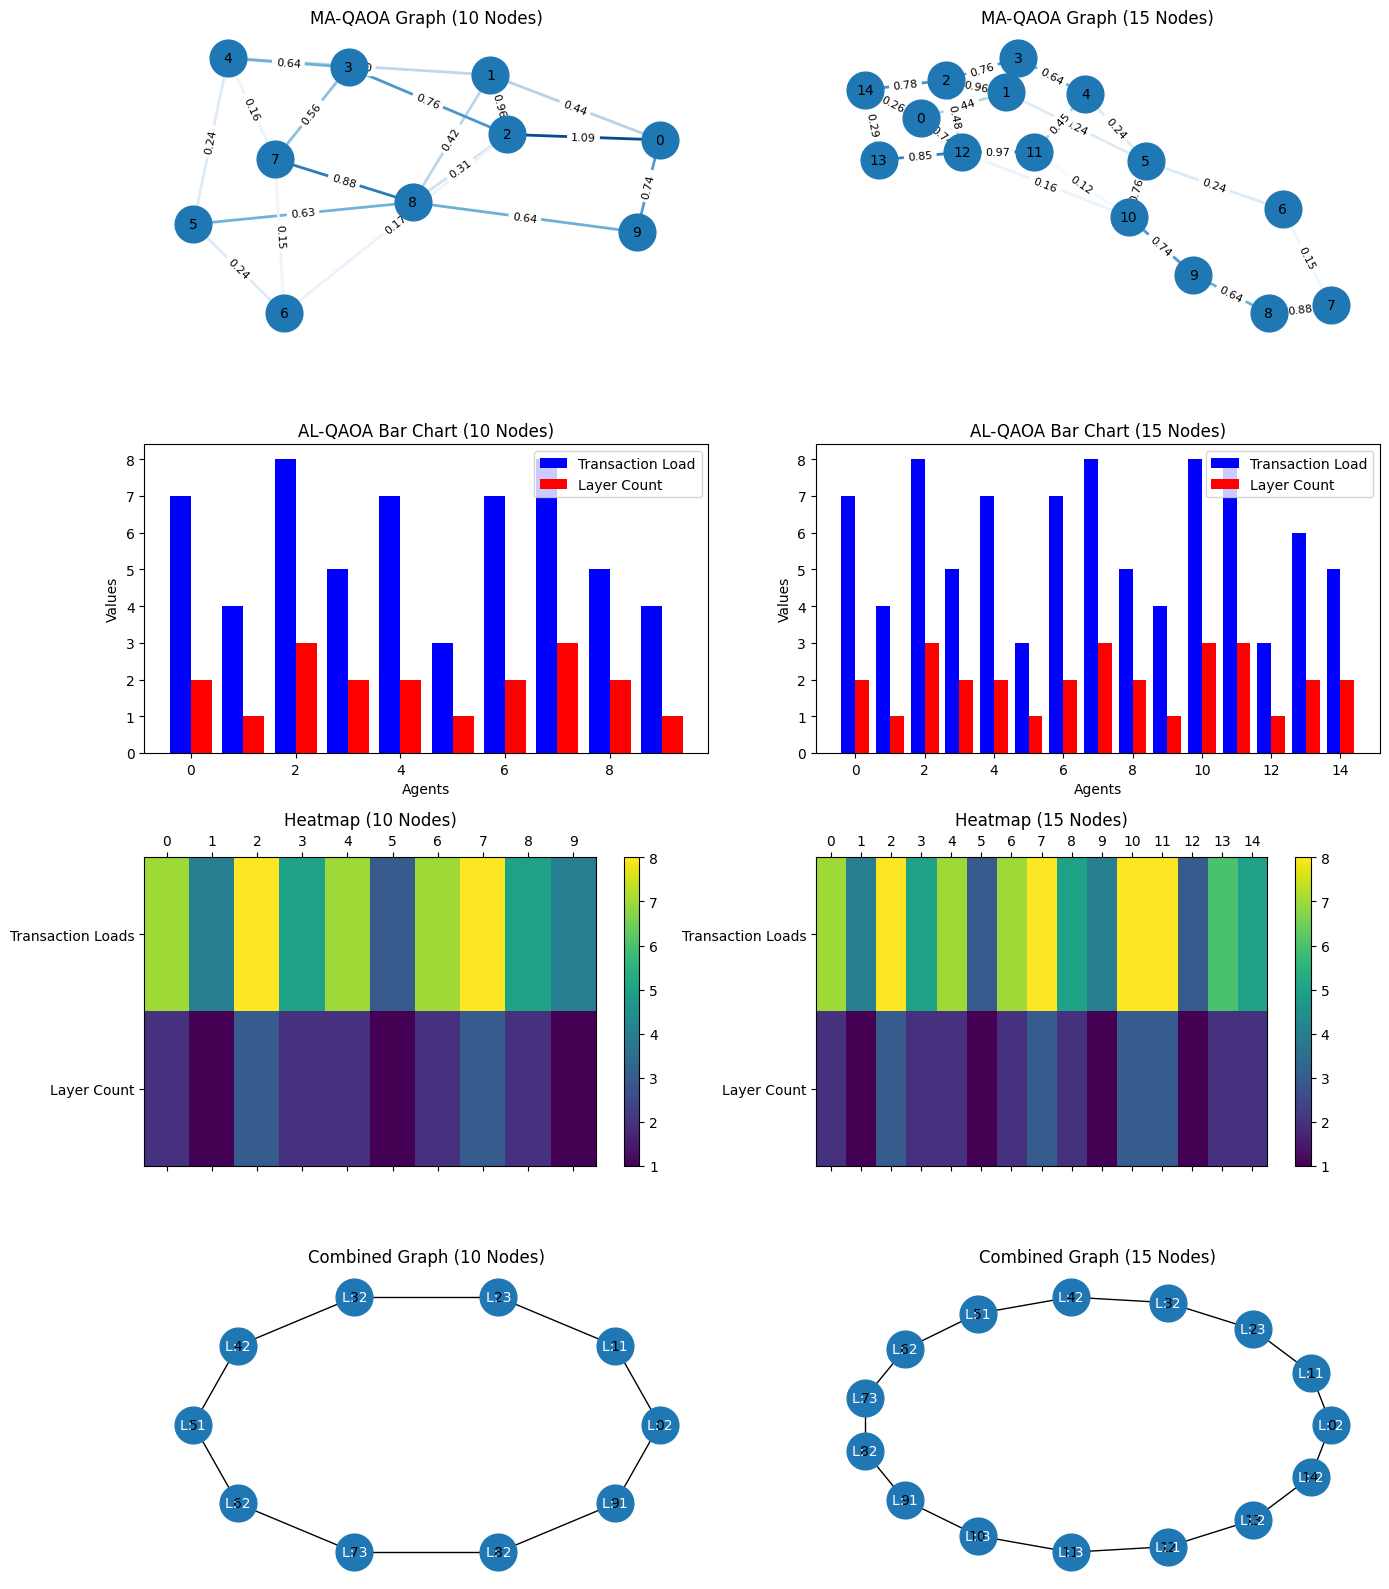

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def ma_qaoa_complex_graph(ax, num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    # Draw the graph
    pos = nx.spring_layout(G, seed=seed)  # Force-directed layout for better visualization
    nx.draw(
        G, pos, ax=ax, with_labels=True, node_size=700, font_size=10,
        edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
        edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2,
        width=2
    )

    # Add edge labels to show weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=8)
    ax.set_title(f"MA-QAOA Graph ({num_nodes} Nodes)")

def al_qaoa_bar_chart(ax, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    x = np.arange(num_agents)
    ax.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
    ax.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
    ax.set_xlabel("Agents")
    ax.set_ylabel("Values")
    ax.set_title(f"AL-QAOA Bar Chart ({num_agents} Nodes)")
    ax.legend()

def combined_representation(ax1, ax2, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    heatmap_data = np.array([transaction_loads, layers])

    # Heatmap
    cax = ax1.matshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(cax, ax=ax1)
    ax1.set_xticks(range(num_agents))
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(["Transaction Loads", "Layer Count"])
    ax1.set_title(f"Heatmap ({num_agents} Nodes)")

    # Overlay on MA-QAOA Graph
    G = nx.Graph()
    for i in range(num_agents):
        G.add_node(i, layer=layers[i])
    edges = [(i, (i + 1) % num_agents) for i in range(num_agents)]
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax2, with_labels=True, node_size=700, font_size=10)
    node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white", ax=ax2)
    ax2.set_title(f"Combined Graph ({num_agents} Nodes)")

# Generate plots for both 10 and 15 nodes
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

for col, num_nodes in enumerate([10, 15]):
    ma_qaoa_complex_graph(axes[0, col], num_nodes=num_nodes)
    al_qaoa_bar_chart(axes[1, col], num_agents=num_nodes)
    combined_representation(axes[2, col], axes[3, col], num_agents=num_nodes)

plt.tight_layout()
plt.show()


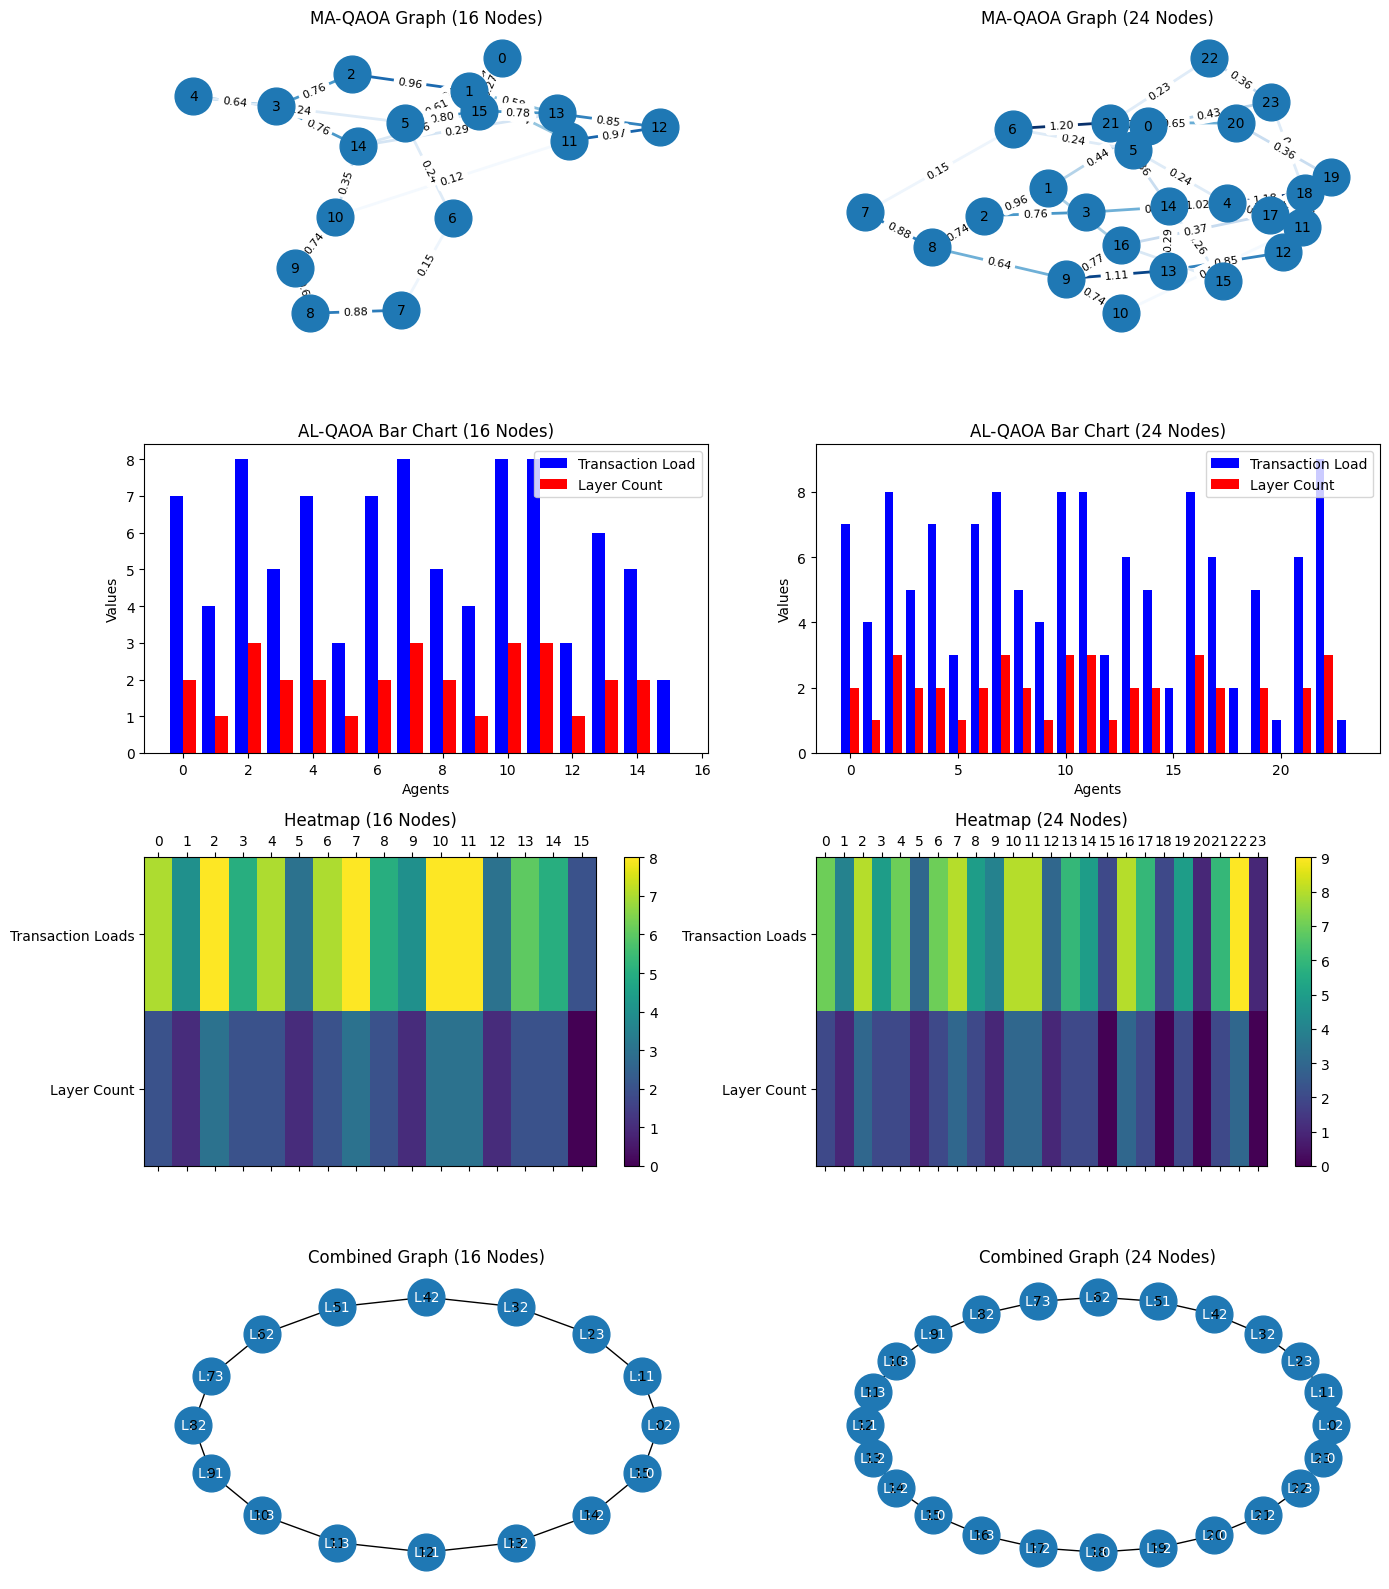

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def ma_qaoa_complex_graph(ax, num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    # Draw the graph
    pos = nx.spring_layout(G, seed=seed)  # Force-directed layout for better visualization
    nx.draw(
        G, pos, ax=ax, with_labels=True, node_size=700, font_size=10,
        edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
        edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2,
        width=2
    )

    # Add edge labels to show weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=8)
    ax.set_title(f"MA-QAOA Graph ({num_nodes} Nodes)")

def al_qaoa_bar_chart(ax, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    x = np.arange(num_agents)
    ax.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
    ax.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
    ax.set_xlabel("Agents")
    ax.set_ylabel("Values")
    ax.set_title(f"AL-QAOA Bar Chart ({num_agents} Nodes)")
    ax.legend()

def combined_representation(ax1, ax2, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    heatmap_data = np.array([transaction_loads, layers])

    # Heatmap
    cax = ax1.matshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(cax, ax=ax1)
    ax1.set_xticks(range(num_agents))
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(["Transaction Loads", "Layer Count"])
    ax1.set_title(f"Heatmap ({num_agents} Nodes)")

    # Overlay on MA-QAOA Graph
    G = nx.Graph()
    for i in range(num_agents):
        G.add_node(i, layer=layers[i])
    edges = [(i, (i + 1) % num_agents) for i in range(num_agents)]
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax2, with_labels=True, node_size=700, font_size=10)
    node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white", ax=ax2)
    ax2.set_title(f"Combined Graph ({num_agents} Nodes)")

# Generate plots for both 10 and 15 nodes
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

for col, num_nodes in enumerate([16, 24]):
    ma_qaoa_complex_graph(axes[0, col], num_nodes=num_nodes)
    al_qaoa_bar_chart(axes[1, col], num_agents=num_nodes)
    combined_representation(axes[2, col], axes[3, col], num_agents=num_nodes)

plt.tight_layout()
plt.show()


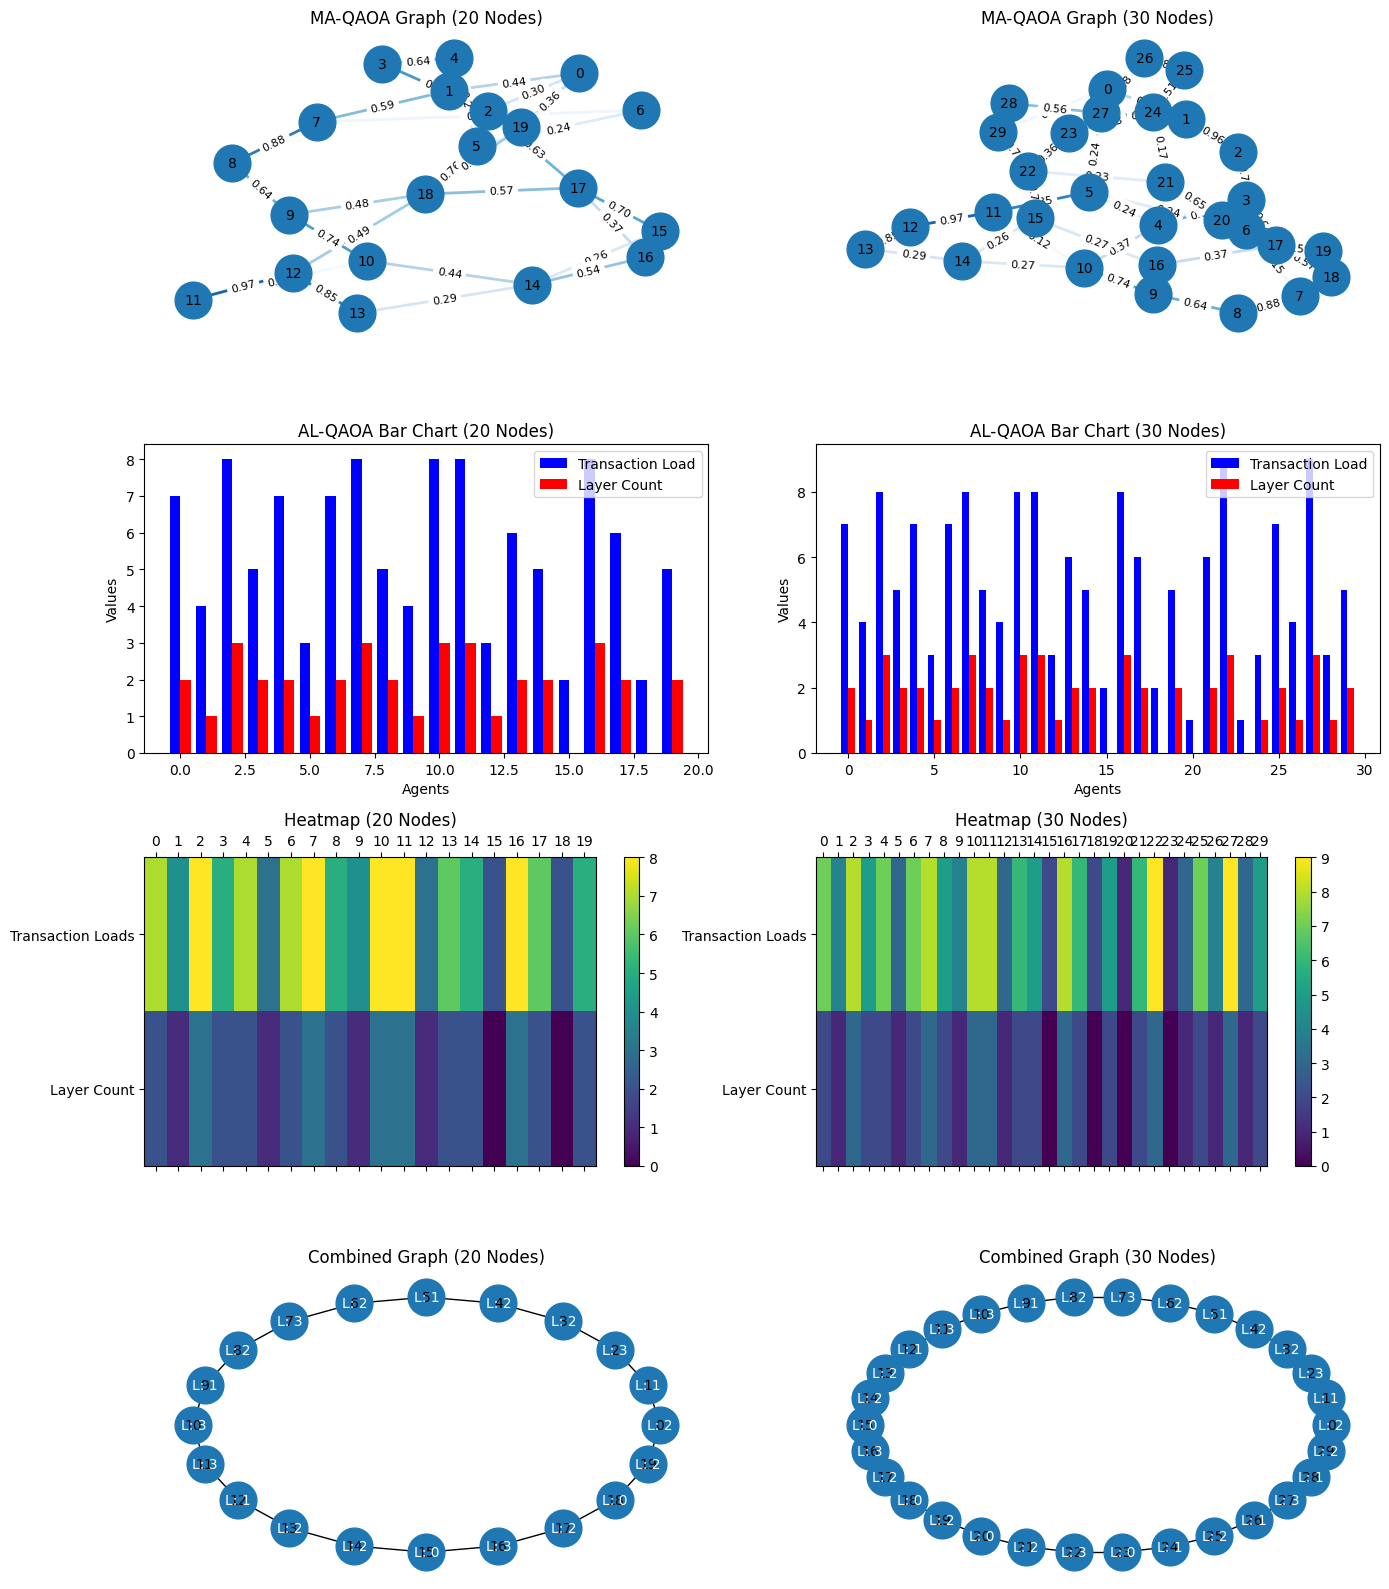

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def ma_qaoa_complex_graph(ax, num_nodes=10, extra_edges=5, seed=42):
    """
    Creates a complex MA-QAOA graph with circular, inner, and random connections.
    """
    np.random.seed(seed)
    G = nx.Graph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add circular edges
    circular_edges = [(i, (i + 1) % num_nodes, {'weight': np.random.uniform(0.1, 1.0)}) for i in range(num_nodes)]
    G.add_edges_from(circular_edges)

    # Add inner edges (non-adjacent nodes)
    inner_edges = []
    while len(inner_edges) < extra_edges:
        u, v = np.random.choice(num_nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) > 1:  # Avoid adjacent nodes
            inner_edges.append((u, v, {'weight': np.random.uniform(0.1, 0.8)}))
    G.add_edges_from(inner_edges)

    # Add random edges with a lower probability
    for _ in range(num_nodes):
        if np.random.rand() < 0.3:  # Random chance for additional connections
            u, v = np.random.choice(num_nodes, 2, replace=False)
            if not G.has_edge(u, v):
                G.add_edge(u, v, weight=np.random.uniform(0.2, 1.2))

    # Draw the graph
    pos = nx.spring_layout(G, seed=seed)  # Force-directed layout for better visualization
    nx.draw(
        G, pos, ax=ax, with_labels=True, node_size=700, font_size=10,
        edge_color=[d['weight'] for (_, _, d) in G.edges(data=True)],
        edge_cmap=plt.cm.Blues, edge_vmin=0.1, edge_vmax=1.2,
        width=2
    )

    # Add edge labels to show weights
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax, font_size=8)
    ax.set_title(f"MA-QAOA Graph ({num_nodes} Nodes)")

def al_qaoa_bar_chart(ax, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    x = np.arange(num_agents)
    ax.bar(x - 0.2, transaction_loads, width=0.4, label="Transaction Load", color='blue')
    ax.bar(x + 0.2, layers, width=0.4, label="Layer Count", color='red')
    ax.set_xlabel("Agents")
    ax.set_ylabel("Values")
    ax.set_title(f"AL-QAOA Bar Chart ({num_agents} Nodes)")
    ax.legend()

def combined_representation(ax1, ax2, num_agents=10, threshold=5, scaling_factor=2, pmax=10):
    np.random.seed(42)
    transaction_loads = np.random.randint(1, 10, num_agents)
    layers = np.minimum(pmax, scaling_factor * transaction_loads / threshold).astype(int)
    heatmap_data = np.array([transaction_loads, layers])

    # Heatmap
    cax = ax1.matshow(heatmap_data, cmap='viridis', aspect='auto')
    plt.colorbar(cax, ax=ax1)
    ax1.set_xticks(range(num_agents))
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(["Transaction Loads", "Layer Count"])
    ax1.set_title(f"Heatmap ({num_agents} Nodes)")

    # Overlay on MA-QAOA Graph
    G = nx.Graph()
    for i in range(num_agents):
        G.add_node(i, layer=layers[i])
    edges = [(i, (i + 1) % num_agents) for i in range(num_agents)]
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, ax=ax2, with_labels=True, node_size=700, font_size=10)
    node_labels = {i: f"L: {layers[i]}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white", ax=ax2)
    ax2.set_title(f"Combined Graph ({num_agents} Nodes)")

# Generate plots for both 10 and 15 nodes
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

for col, num_nodes in enumerate([20, 30]):
    ma_qaoa_complex_graph(axes[0, col], num_nodes=num_nodes)
    al_qaoa_bar_chart(axes[1, col], num_agents=num_nodes)
    combined_representation(axes[2, col], axes[3, col], num_agents=num_nodes)

plt.tight_layout()
plt.show()
